In [1]:
import      numpy               as      np
import      matplotlib.pyplot   as      plt
from        lib_Experimentum    import  *
from        Alessandria         import  *


#path dove stanno i dati del fit
now_path        =   '../BRILLOUIN/TDP43/ARS_13_02/analysis_best_cutted/'

### recupero info su dimensionalità
spectra_path = '../BRILLOUIN/TDP43/ARS_13_02/'
spectra_filename    =   'ARS_13_02'
n_rows    =   len(Import_from_Matlab(spectra_filename, spectra_path, var_name = 'y3'))
n_cols  =   len(Import_from_Matlab(spectra_filename, spectra_path, var_name = 'y3')[0])
###
matrix, rows, cols = Initialize_Matrix(0,0,n_rows,n_cols)

Ho inizializzato una matrice 89x85, per un totale di 7565 spettri


In [2]:

#1) Recupero info su posizioni + info su chi è bono e chi no e su VIPA (questo solo per matrix[0][0])

with open(now_path+'xy.txt', 'r') as fin:
    lines = fin.readlines()[1:]

excluded = ()

with open(now_path+'markov_fit.txt', 'r') as fin:
    fit     =   eval(fin.read())
_,_,_, boni = Unpack_Fit(fit)

"""
with open(now_path+'xy_VIPA.txt', 'r') as fin:
    VIPAs = fin.readlines()[1:]

x_VIPA = np.array(VIPAs[0][1:-2].split(), dtype=float)
y_VIPA = np.array(VIPAs[1][1:-2].split(), dtype=float)

matrix[0][0].Recover_VIPA(x_VIPA, y_VIPA)
"""
count = 0
for ii in range(len(rows)):
    for jj in range(len(cols)):
        #print(str((ii,jj)))
        matrix[ii][jj].Recover_Spectrum(np.array(lines[count][1:-2].split(), dtype=float), np.array(lines[count+1][1:-2].split(), dtype=float))
        
        if (ii,jj) not in boni:
            excluded = excluded +((ii,jj),)

        count = count + 2

print('Ok ho recuperato le informazioni sulle posizioni')

Ok ho recuperato le informazioni sulle posizioni


In [3]:
#2) Acquisico i dati prodotti dal fit markoviano


##################### MARKOVIANO

with open(now_path+'y_markov_fit.txt', 'r') as fin:
    y_fits = fin.readlines()

with open(now_path+'cost_markov.txt', 'r') as fin:
    costi = fin.readlines()

with open(now_path+'markov_fit_params.txt', 'r') as fin:
    lines   =   fin.readlines()

if (len(boni) != len(lines)):
    raise ValueError("Incompatibilità tra lunghezza file parametri ({}) e informazioni fit ({})".format(len(boni), len(lines)))

for (line, y_fit, cost, (ii,jj)) in zip(lines, y_fits, costi,  boni) :
#for (line, cost, (ii,jj)) in zip(lines, costi,   boni) :
    matrix[ii][jj].Recover_Markov_Fit_Params(line)
    matrix[ii][jj].Recover_y_markov_fit(np.array(y_fit[1:-2].split(), dtype = float))
    matrix[ii][jj].Recover_cost_markov(float(cost))

print('Ok ho recuperato le informazioni del Fit Markoviano')



Ok ho recuperato le informazioni del Fit Markoviano


In [31]:
omega_too_high = Whose_Param_Too_High('Omega', 8.2, 'markov', matrix, boni)
print(len(omega_too_high))
gamma_too_high = Whose_Param_Too_High('Gamma', 0.35, 'markov', matrix, boni)
print(len(gamma_too_high))



0
(30, 28) ha Gamma= 0.38
(31, 27) ha Gamma= 0.66
(38, 30) ha Gamma= 0.60
(38, 32) ha Gamma= 0.38
(39, 31) ha Gamma= 0.36
(39, 32) ha Gamma= 0.37
(42, 20) ha Gamma= 0.42
(49, 10) ha Gamma= 0.36
(50, 41) ha Gamma= 0.58
(50, 42) ha Gamma= 0.43
(50, 43) ha Gamma= 0.40
(50, 44) ha Gamma= 0.68
(50, 45) ha Gamma= 0.39
(50, 48) ha Gamma= 0.49
(51, 41) ha Gamma= 0.69
(51, 43) ha Gamma= 0.43
(51, 44) ha Gamma= 0.36
(51, 45) ha Gamma= 0.44
(51, 46) ha Gamma= 0.36
(51, 48) ha Gamma= 0.42
(52, 40) ha Gamma= 0.36
(52, 41) ha Gamma= 0.67
(67, 54) ha Gamma= 0.35
(70, 50) ha Gamma= 0.44
(82, 21) ha Gamma= 0.36
(85, 20) ha Gamma= 0.35
26


In [20]:
def Get_Bad_Elements(matrix, iterable, treshold ):
    too_bad = ()
    for (ii,jj) in iterable:
        if matrix[ii][jj].cost_markov > treshold:
            too_bad += ((ii,jj),)
    print('I found {} bad elements \n'.format(len(too_bad)))
    return too_bad
def Get_Good_Elements(matrix, iterable, treshold ):
    too_good = ()
    for (ii,jj) in iterable:
        if matrix[ii][jj].cost_markov > treshold:
            too_good += ((ii,jj),)
    print('I found {} good elements \n'.format(len(too_good)))
    return too_good
def Zoom_Plot(matrix, elements_iterable, x_range = (), y_range = (), fit = False):
    if fit == 'markov':
        attr = 'y_markov_fit'
    elif fit == 'tot':
        attr = 'y_fit'

    for(ii,jj) in elements_iterable:
        plt.figure()
        plt.title(str((ii,jj)))
        plt.plot(matrix[ii][jj].x_freq, matrix[ii][jj].y, '+', label = 'data')
        if fit:
            plt.plot(matrix[ii][jj].x_freq, getattr(matrix[ii][jj], attr), label = fit+' fit')
        plt.xlim(x_range[0], x_range[1])
        plt.ylim(y_range[0], y_range[1])
        plt.legend()
        plt.show()

In [21]:
too_bad = Get_Bad_Elements(matrix, boni, 1200)

I found 1 bad elements 



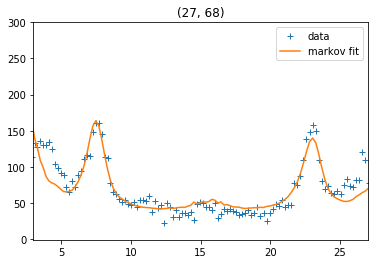

(27, 68)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.131331  7.230803  0.246776        0.091122     0.027904   
StdErrs   0.034592  0.030123  0.024705        0.029652     0.001510   
Initials  0.100000  7.795377  0.100000        0.000000     0.050000   

          delta_amplitude             A         mu      sigma     shift  \
Values           1.060610  5.455538e+03  12.149215  20.148962  0.356806   
StdErrs          0.042394  3.893166e+09   3.172333  12.657023  0.029696   
Initials         0.100000  4.546282e+03  11.962272  16.790802  0.000000   

             offset  
Values    32.101430  
StdErrs    1.227517  
Initials   0.000000  


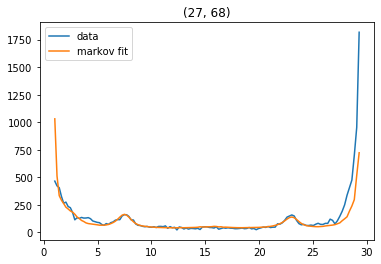

In [26]:
Zoom_Plot(matrix, too_bad, (3, 27), (-1, 300), fit = 'markov')
Plot_Elements_Spectrum(matrix, too_bad, fit = 'markov')

In [23]:
matrix[27][68].Markov_Fit_Params

,Co,Omega,Gamma,delta_position,delta_width,delta_amplitude,A,mu,sigma,shift,offset
Values,0.131331,7.230803,0.246776,0.091122,0.027904,1.060610,5.455538e+03,12.149215,20.148962,0.356806,32.101430
StdErrs,0.034592,0.030123,0.024705,0.029652,0.001510,0.042394,3.893166e+09,3.172333,12.657023,0.029696,1.227517
Initials,0.100000,7.795377,0.100000,0.000000,0.050000,0.100000,4.546282e+03,11.962272,16.790802,0.000000,0.000000


In [16]:
too_good = Get_Good_Elements(matrix, boni, 100)

I found 554 good elements 



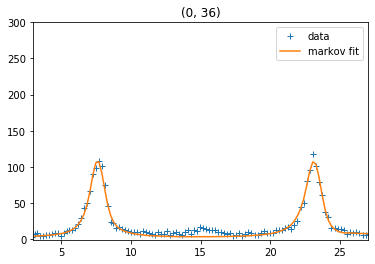

(0, 36)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.081511  7.244183  0.163763       -0.721487     0.016236   
StdErrs   0.082772  0.021392  0.013935        0.021097     0.003848   
Initials  0.100000  7.795377  0.100000        0.000000     0.050000   

          delta_amplitude             A         mu      sigma     shift  \
Values           0.021439  4.486952e+03  10.407430  14.014976  0.461297   
StdErrs          0.006555  9.191230e+09   9.323702  17.054197  0.020912   
Initials         0.100000  4.546282e+03  11.962272  16.790802  0.000000   

            offset  
Values    1.092631  
StdErrs   0.543591  
Initials  0.000000  


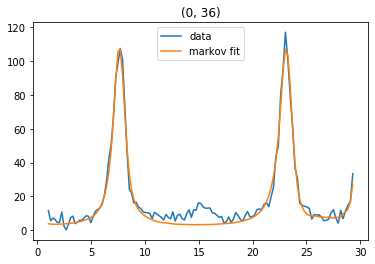

In [28]:
Zoom_Plot(matrix, too_good[:1], (3, 27), (-1, 300), fit = 'markov')
Plot_Elements_Spectrum(matrix, [(0,36),], fit = 'markov')

In [25]:
matrix[0][36].Markov_Fit_Params


,Co,Omega,Gamma,delta_position,delta_width,delta_amplitude,A,mu,sigma,shift,offset
Values,0.081511,7.244183,0.163763,-0.721487,0.016236,0.021439,4.486952e+03,10.407430,14.014976,0.461297,1.092631
StdErrs,0.082772,0.021392,0.013935,0.021097,0.003848,0.006555,9.191230e+09,9.323702,17.054197,0.020912,0.543591
Initials,0.100000,7.795377,0.100000,0.000000,0.050000,0.100000,4.546282e+03,11.962272,16.790802,0.000000,0.000000


Completata Parameter_Map per Omega
Ho trovato 15 elementi saturati


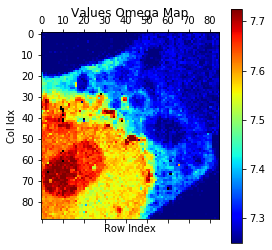

Completata Parameter_Map per Omega
Ho trovato 15 elementi saturati


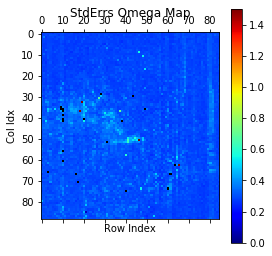

Completata Parameter_Map per Gamma
Ho trovato 15 elementi saturati


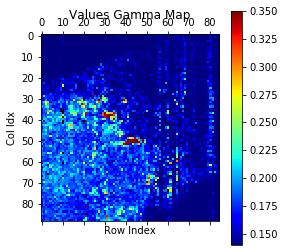

Completata Parameter_Map per Gamma
Ho trovato 15 elementi saturati


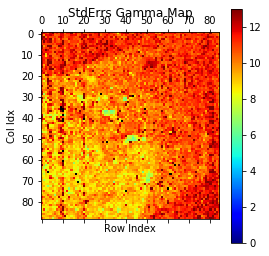

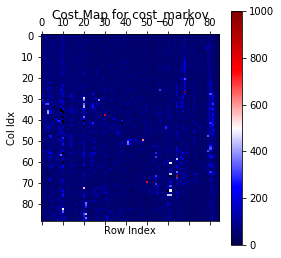

In [32]:
omega_markov_map, _ = Get_Parameter_Map('markov', 'Omega', matrix, n_rows, n_cols, excluded, 'jet', 7.25, 7.725, fig = 'omega_markov_map', path=now_path)
Delta_omega_markov_map, _ = Get_Parameter_Map('markov', 'Omega', matrix, n_rows, n_cols, excluded, 'jet', 0,1.5, fig = 'Delta_omega_markov_map', path=now_path, Deltas = True)
gamma_markov_map, _ = Get_Parameter_Map('markov', 'Gamma', matrix, n_rows, n_cols, excluded, 'jet', 0.14,0.35, fig = 'Gamma_markov_map', path=now_path)
Delta_gamma_markov_map, _ = Get_Parameter_Map('markov', 'Gamma', matrix, n_rows, n_cols, excluded, 'jet', 0 , 13, fig = 'Delta_Gamma_markov_map', path=now_path, Deltas = True)
markov_cost_map = Get_cost_map(matrix, 'markov', len(rows), len(cols), 'markov_cost_map', path = now_path)

In [11]:
################ TOTALE

with open(now_path+'y_tot_fit.txt', 'r') as fin:
    y_fits = fin.readlines()

with open(now_path+'cost_tot.txt', 'r') as fin:
    costi = fin.readlines()
with open(now_path+'tot_fit_params.txt', 'r') as fin:
    lines   =   fin.readlines()

if (len(boni) != len(lines)):
    raise ValueError("Incompatibilità tra lunghezza file parametri ({}) e informazioni fit ({})".format(len(boni), len(lines)))

for (line, y_fit, cost, (ii,jj)) in zip(lines, y_fits, costi,  boni) :
#for (line, cost, (ii,jj)) in zip(lines, costi,  boni) :
    matrix[ii][jj].Recover_Tot_Fit_Params(line)
    matrix[ii][jj].Recover_y_fit(np.array(y_fit[1:-2].split(), dtype = float))
    matrix[ii][jj].Recover_cost_tot(float(cost))

print('Ok ho recuperato le informazioni del Fit Totale')

Ok ho recuperato le informazioni del Fit Totale


(60, 15)


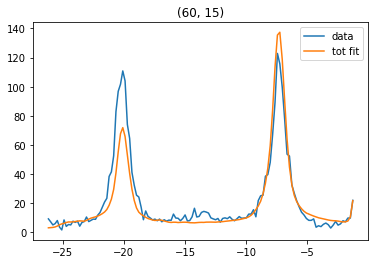

(60, 16)


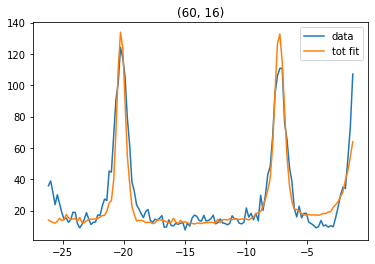

(60, 17)


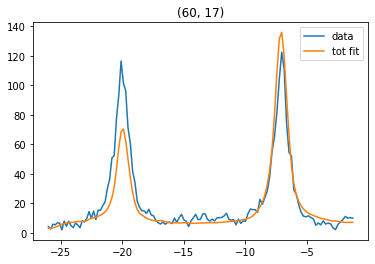

(60, 18)


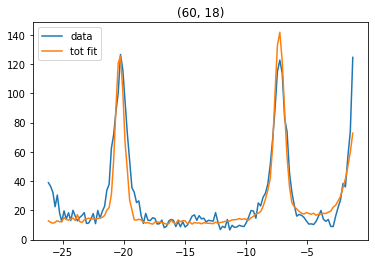

In [12]:
Plot_Elements_Spectrum(matrix, ((60, 15), (60, 16), (60, 17), (60,18)), fit = 'tot')

In [16]:
omega_tot_map, _ = Get_Parameter_Map('tot', 'Omega', matrix, n_rows, n_cols, excluded, 'seismic', 7.3, 8.65, fig = 'omega_tot_map', path=now_path)
Delta_omega_tot_map, _ = Get_Parameter_Map('tot', 'Omega', matrix, n_rows, n_cols, excluded, 'seismic', 0,0.7, fig = 'Delta_omega_tot_map', path=now_path, Deltas = True)
gamma_tot_map, _ = Get_Parameter_Map('tot', 'Gamma', matrix, n_rows, n_cols, excluded, 'seismic', 0.1,0.25, fig = 'Gamma_tot_map', path=now_path)
Delta_gamma_tot_map, _ = Get_Parameter_Map('tot', 'Gamma', matrix, n_rows, n_cols, excluded, 'seismic', 0,0.05, fig = 'Delta_gamma_tot_map', path=now_path, Deltas = True)
tau_map, _ = Get_Parameter_Map('tot', 'tau', matrix, n_rows, n_cols, excluded, 'seismic', 0., 1., fig = 'tau_map', path=now_path)
Delta_tau_map, _ = Get_Parameter_Map('tot', 'tau', matrix, n_rows, n_cols, excluded, 'seismic', 0,0.7, fig = 'Delta_tau_map', path=now_path, Deltas = True)

AttributeError: 'Spectrum' object has no attribute 'Tot_Fit_Params'

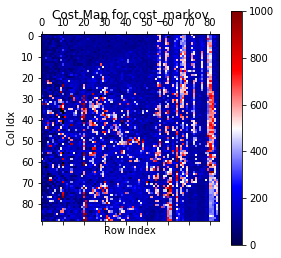

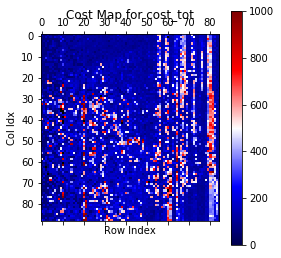

In [30]:
markov_cost_map = Get_cost_map(matrix, 'markov', len(rows), len(cols), 'markov_cost_map', path = now_path)
tot_cost_map = Get_cost_map(matrix, 'tot', len(rows), len(cols), 'tot_cost_map', path = now_path)


(0, 0)


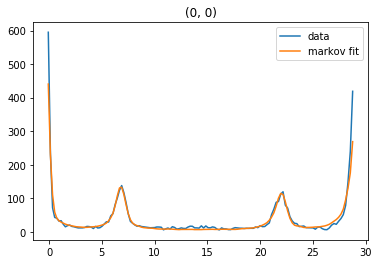

(0, 1)


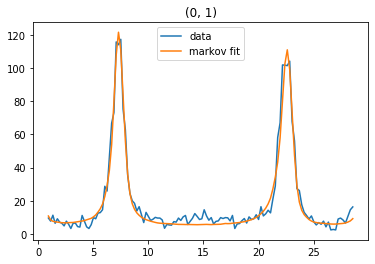

(0, 2)


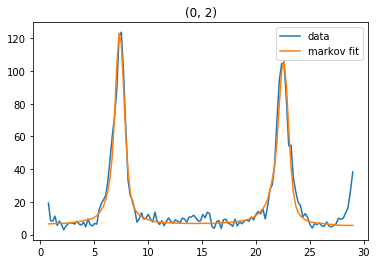

(0, 3)


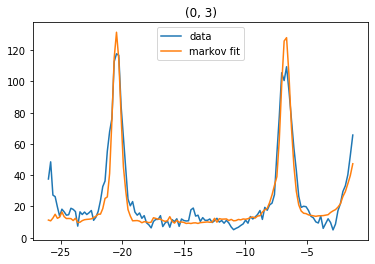

(0, 4)


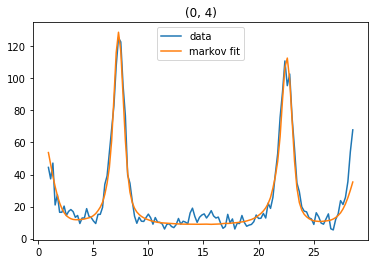

(0, 5)


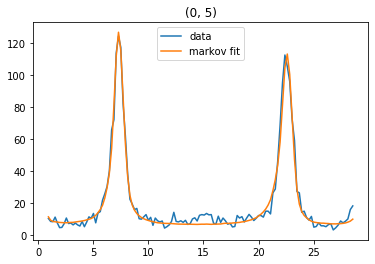

(0, 6)


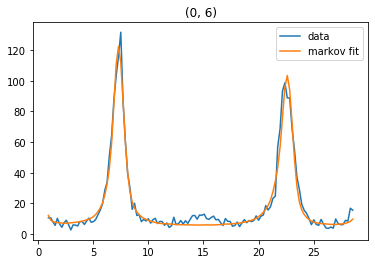

(0, 7)


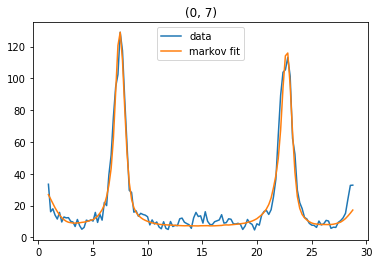

(0, 8)


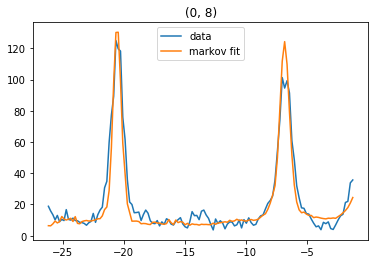

(0, 9)


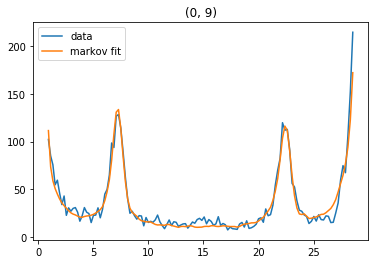

(0, 10)


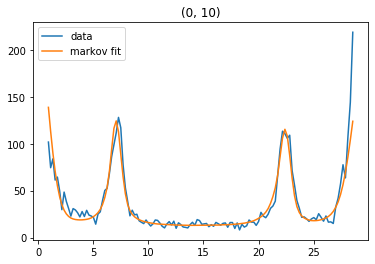

(0, 11)


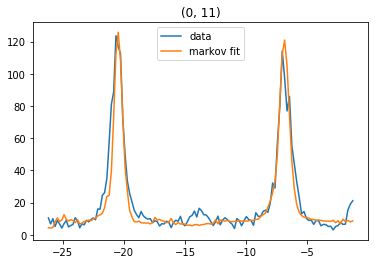

(0, 12)


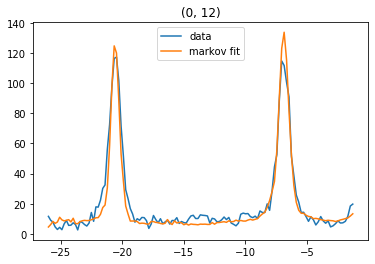

(0, 13)


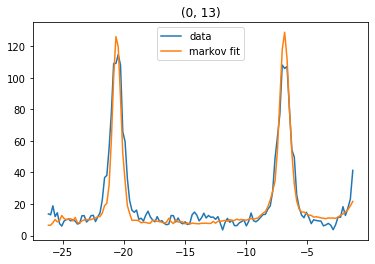

(0, 14)


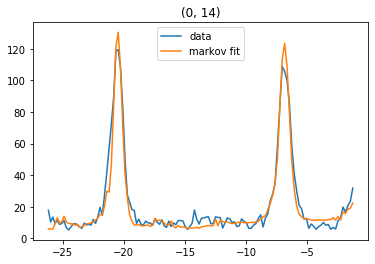

(0, 15)


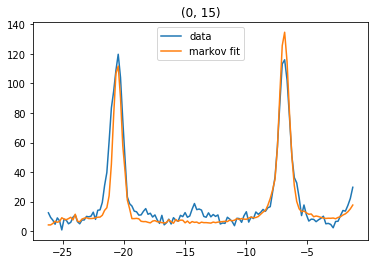

(0, 16)


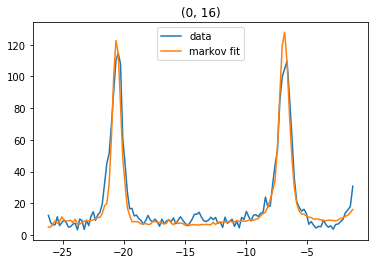

(0, 17)


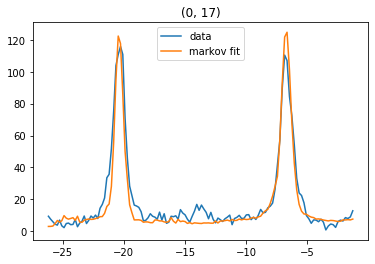

(0, 18)


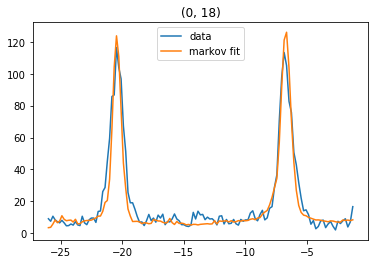

(0, 19)


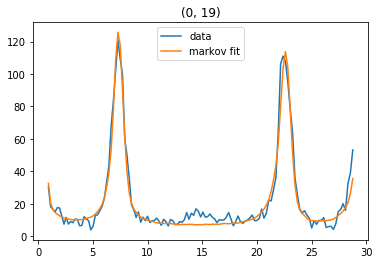

In [33]:
Plot_Elements_Spectrum(matrix, boni[0:20], fit = 'markov')

In [34]:
for (ii,jj) in boni[0:20]:
    print(matrix[ii][jj].Markov_Fit_Params)


Co     Omega     Gamma  delta_width  delta_amplitude  \
Values    0.690403  7.380093  0.119961     0.346559         4.526239   
StdErrs   0.242094  0.019344  0.013036     0.036666         0.880408   
Initials  1.000000  7.653411  0.613204     0.500000         0.100000   

                     A         mu      sigma     shift     offset  
Values    6.848283e+02  10.409714  18.377639 -0.590578   0.756907  
StdErrs   7.409484e+08   7.496846  13.116684  0.015237   0.704313  
Initials  6.226355e+02  10.851784  16.706945  0.000000  22.742063  
                Co     Omega     Gamma  delta_width  delta_amplitude  \
Values    0.576202  7.352200  0.103899     0.331096         0.327227   
StdErrs   0.931994  0.021399  0.013048     0.302070         0.579251   
Initials  1.000000  7.653411  0.613204     0.500000         0.100000   

                     A         mu      sigma     shift     offset  
Values    6.574410e+02   9.766605  15.731842 -0.046762   3.331091  
StdErrs   1.392425e+09  24.854